## Title: Time Series Forecasting
- Author: Yiran Jing
- Semster 2, 2017

#### DataSet description
Over 3000 Rossmann drug stores in 7 European countries. 
#### business objective
Forecast six weeks daily sales for several stores by developing a univariate forecasting model.

### Summary
The objective of this forecast is to ensure that store manager could make an effective staff arrangement that enhances the productivity and motivation. The time series forecasting relies on basic understanding of time series composition and model selection. Therefore, we perform EDA to understand the pattern with the time-varying data and select ARIMA and Exponential moving average method as potential choices to formulate robust model.



### Content within this Notebook:
- Data Cleaning
 - Rescale the series to be in millions of rides, to facilitate the intepretation and avoid possible numerical problems.
 - Rrop sunday since store closed
 - we also clean data when open=0
 - and after our check , we decide to remove 180 stores, with imcompleted information
- EDA 
 - Time series decomposition
 - Seasonal plot
- Stationary Transformation
 - AutoCorrelation and Partial AutoCorrelation Plot for Stationary checking
 - First difference and Seasonal difference
- Modeling (Automatic selection by AIC)
 - ARIMA
 - Holt-winters Exponential Smoothing
- Residual diagnostics 
 - ACF and PACF plots (Residual vs Time)
 - Residual distribution (histogram and QQ plot)
- Model Validation
 - RMSE one day, one week and six weeks ahead
- Forecast

 

In [52]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [69]:
# Time series plot
def ts_plot(y, color=red):
    fig, ax= plt.subplots(figsize=(8,5))
    y.plot(color=color, ax=ax)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True)
    sns.despine()
    return fig, ax

# ACF and PACF plots
def acf_pacf_plot(y):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
    sns.despine()
    fig.tight_layout()
    return fig, ax

#Histogram
def hist(y):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(y, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

###  Data Cleaning and Feature Engineering
- Rescale the series to be in millions of rides, to facilitate the intepretation and avoid possible numerical problems.
- Rrop sunday since store closed
- we also clean data when open=0
- and after our check , we decide to remove 180 stores, with imcompleted information

In [70]:
rossmann_df  = pd.read_csv("Rossman Sales.csv")
rossmann_df=rossmann_df[rossmann_df['DayOfWeek']!=7]
sales = rossmann_df.groupby('Date')['Sales'].sum()
sales['2013-01-01']=sales['2013-01-08']
sales['2014-01-01']=sales['2014-01-08']
sales['2015-01-01']=sales['2015-01-08']
sales['2013-12-25']=sales['2013-12-18']
sales['2014-12-25']=sales['2014-12-18']
sales['2013-12-26']=sales['2013-12-19']
sales['2013-05-01']=sales['2013-05-08']
sales['2014-12-26']=sales['2014-12-19']
sales['2013-03-29']=sales['2013-03-22']
sales['2014-04-18']=sales['2014-04-11']
sales['2013-05-09']=sales['2013-05-17']
sales['2014-05-01']=sales['2014-05-08']

sales['2015-04-06']=sales['2015-04-13']
sales['2013-10-03']=sales['2013-10-10']
sales['2014-06-09']=sales['2014-06-16']
sales['2015-05-14']=sales['2015-05-21']
sales['2015-05-25']=sales['2015-06-01']
sales['2014-10-03']=sales['2014-10-10']

sales['2013-05-20']=sales['2013-05-27']
sales['2015-05-01']=sales['2015-05-08']
sales['2014-05-29']=sales['2014-05-22']
sales['2013-04-01']=sales['2013-04-08']
sales['2015-04-03']=sales['2015-04-10']
sales['2014-04-21']=sales['2014-04-28']

y_=sales.reset_index()
y_.set_index('Date',inplace=True)
y_.index = pd.to_datetime(y_.index)

y_=y_/(10**5)

y_.head()

,Sales
Date,
2013-01-01,87.49437
2013-01-02,69.49829
2013-01-03,63.47820
2013-01-04,66.38954
2013-01-05,59.51593


In [71]:
data=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
data=data[data['DayOfWeek']!=7]
data.index=data.index.to_period(freq='D')
grouped = data.groupby('Date')
sales = grouped.aggregate(np.sum)
y=sales['Sales']
y['2013-01-01']=y['2013-01-08']
y['2014-01-01']=y['2014-01-08']
y['2015-01-01']=y['2015-01-08']
y['2013-12-25']=y['2013-12-18']
y['2014-12-25']=y['2014-12-18']
y['2013-12-26']=y['2013-12-19']
y['2013-05-01']=y['2013-05-08']
y['2014-12-26']=y['2014-12-19']
y['2013-03-29']=y['2013-03-22']
y['2014-04-18']=y['2014-04-11']
y['2013-05-09']=y['2013-05-17']
y['2014-05-01']=y['2014-05-08']
y['2015-04-06']=y['2015-04-13']
y['2013-10-03']=y['2013-10-10']
y['2014-06-09']=y['2014-06-16']
y['2015-05-14']=y['2015-05-21']
y['2015-05-25']=y['2015-06-01']
y['2014-10-03']=y['2014-10-10']
y['2013-05-20']=y['2013-05-27']
y['2015-05-01']=y['2015-05-08']
y['2014-05-29']=y['2014-05-22']
y['2013-04-01']=y['2013-04-08']
y['2015-04-03']=y['2015-04-10']
y['2014-04-21']=y['2014-04-28']
y=y/(10**5)
y.head()

Date
2013-01-01    87.49437
2013-01-02    69.49829
2013-01-03    63.47820
2013-01-04    66.38954
2013-01-05    59.51593
Freq: D, Name: Sales, dtype: float64

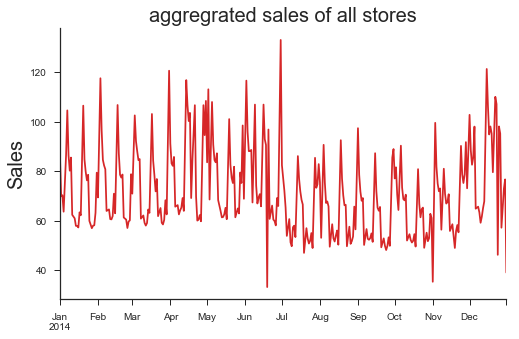

In [72]:
fig, ax= ts_plot(y['2014-01-01':'2014-12-31'])
ax.set_ylabel('Sales', fontsize=20)
ax.set_title('aggregrated sales of all stores', fontsize=20)
plt.show()

drop 180 stores¶

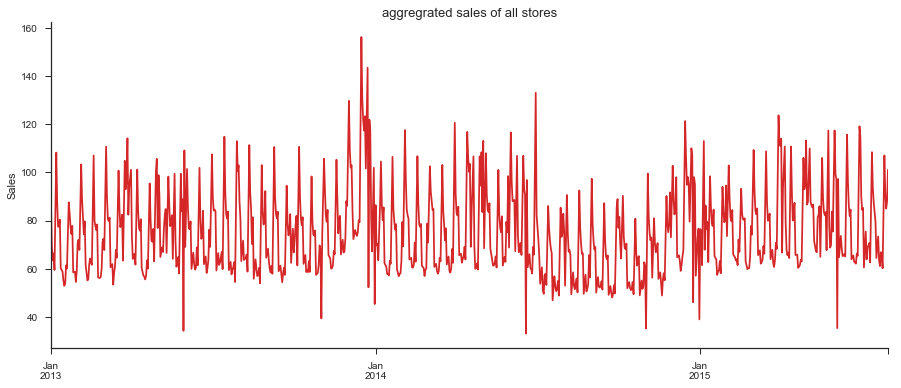

The store 988 has 807 record. 

There are 180 stores only have 650 records, the names of them  are : 
[13, 20, 22, 32, 36, 41, 46, 51, 52, 58, 72, 76, 81, 89, 99, 100, 108, 113, 115, 127, 129, 132, 136, 137, 139, 144, 145, 149, 155, 159, 164, 165, 172, 174, 181, 183, 186, 190, 191, 192, 204, 215, 218, 231, 243, 258, 263, 275, 277, 279, 283, 284, 287, 288, 298, 306, 317, 342, 345, 348, 365, 385, 399, 407, 412, 413, 420, 427, 428, 429, 430, 434, 457, 471, 477, 485, 490, 492, 498, 500, 501, 512, 514, 518, 522, 534, 539, 540, 542, 547, 555, 571, 573, 575, 587, 598, 604, 611, 612, 619, 620, 629, 633, 636, 637, 638, 644, 646, 650, 660, 669, 670, 671, 677, 684, 694, 701, 702, 706, 710, 711, 712, 716, 719, 736, 739, 744, 750, 766, 771, 775, 778, 797, 804, 805, 806, 815, 820, 825, 842, 851, 858, 859, 879, 884, 890, 893, 900, 902, 903, 904, 909, 915, 919, 920, 932, 941, 952, 974, 977, 989, 1000, 1004, 1009, 1012, 1019, 1027, 1038, 1041, 1049, 1056, 1065, 1067, 1080, 1092, 1094, 1102, 1104, 1107,

In [56]:
fig, ax= ts_plot(y)
ax.set_ylabel('Sales')
ax.set_title('aggregrated sales of all stores', fontsize=13)
plt.show()

rossmann_df  = pd.read_csv("Rossman Sales.csv")
rossmann_df=rossmann_df[rossmann_df['DayOfWeek']!=7]
sales = rossmann_df.groupby('Date')['Sales'].sum()
sales=sales['2014-07-01':]

# generate list of 180 stores
x=range(1 , 1116)
record650=[]
record_other=[]
for i in x:
    if len(rossmann_df[rossmann_df['Store']==i]) != 808:
        if len(rossmann_df[rossmann_df['Store']==i]) == 650:
            record650.append(i)
        else:
            record_other.append(i)
            print("The store "+ str(i) + " has " +  str(len(rossmann_df[rossmann_df['Store']==i]))+ " record. ")
        continue
print()
print("There are " +str(len(record650)) +" stores only have 650 records, the names of them  are : ")
print(record650)

In [73]:
data=pd.read_csv('Rossman Sales.csv', index_col='Date', parse_dates=True, dayfirst=True)
data=data[data['DayOfWeek']!=7]

x=range(1 , len(record650))
for i in x:
    data=data[data["Store"]!=record650[i]]

data.index=data.index.to_period(freq='D')
grouped = data.groupby('Date')
sales = grouped.aggregate(np.sum)
y=sales['Sales']
y['2013-01-01']=y['2013-01-08']
y['2014-01-01']=y['2014-01-08']
y['2015-01-01']=y['2015-01-08']
y['2013-12-25']=y['2013-12-18']
y['2014-12-25']=y['2014-12-18']
y['2013-12-26']=y['2013-12-19']
y['2013-05-01']=y['2013-05-08']
y['2014-12-26']=y['2014-12-19']
y['2013-03-29']=y['2013-03-22']
y['2014-04-18']=y['2014-04-11']
y['2013-05-09']=y['2013-05-17']
y['2014-05-01']=y['2014-05-08']
y['2015-04-06']=y['2015-04-13']
y['2013-10-03']=y['2013-10-10']
y['2014-06-09']=y['2014-06-16']
y['2015-05-14']=y['2015-05-21']
y['2015-05-25']=y['2015-06-01']
y['2014-10-03']=y['2014-10-10']
y['2013-05-20']=y['2013-05-27']
y['2015-05-01']=y['2015-05-08']
y['2014-05-29']=y['2014-05-22']
y['2013-04-01']=y['2013-04-08']
y['2015-04-03']=y['2015-04-10']
y['2014-04-21']=y['2014-04-28']
y=y/(10**5)
y.head()

Date
2013-01-01    74.30273
2013-01-02    58.93643
2013-01-03    54.05806
2013-01-04    56.33244
2013-01-05    49.80300
Freq: D, Name: Sales, dtype: float64

In [74]:
rossmann_df  = pd.read_csv("Rossman Sales.csv")
rossmann_df=rossmann_df[rossmann_df['DayOfWeek']!=7]
x=range(1 , len(record650))
for i in x:
    rossmann_df=rossmann_df[rossmann_df["Store"]!=record650[i]]

sales = rossmann_df.groupby('Date')['Sales'].sum()
sales['2013-01-01']=sales['2013-01-08']
sales['2014-01-01']=sales['2014-01-08']
sales['2015-01-01']=sales['2015-01-08']
sales['2013-12-25']=sales['2013-12-18']
sales['2014-12-25']=sales['2014-12-18']
sales['2013-12-26']=sales['2013-12-19']
sales['2013-05-01']=sales['2013-05-08']
sales['2014-12-26']=sales['2014-12-19']
sales['2013-03-29']=sales['2013-03-22']
sales['2014-04-18']=sales['2014-04-11']
sales['2013-05-09']=sales['2013-05-17']
sales['2014-05-01']=sales['2014-05-08']

sales['2015-04-06']=sales['2015-04-13']
sales['2013-10-03']=sales['2013-10-10']
sales['2014-06-09']=sales['2014-06-16']
sales['2015-05-14']=sales['2015-05-21']
sales['2015-05-25']=sales['2015-06-01']
sales['2014-10-03']=sales['2014-10-10']

sales['2013-05-20']=sales['2013-05-27']
sales['2015-05-01']=sales['2015-05-08']
sales['2014-05-29']=sales['2014-05-22']
sales['2013-04-01']=sales['2013-04-08']
sales['2015-04-03']=sales['2015-04-10']
sales['2014-04-21']=sales['2014-04-28']

y_=sales.reset_index()
y_.set_index('Date',inplace=True)
y_.index = pd.to_datetime(y_.index)

y_=y_/(10**5)

y_.head()

,Sales
Date,
2013-01-01,74.30273
2013-01-02,58.93643
2013-01-03,54.05806
2013-01-04,56.33244
2013-01-05,49.80300


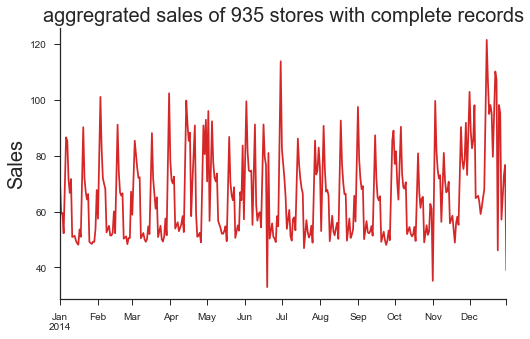

In [75]:
fig, ax= ts_plot(y['2014-01-01':'2014-12-31'])
ax.set_ylabel('Sales', fontsize=20)
ax.set_title('aggregrated sales of 935 stores with complete records', fontsize=20)
plt.show()

# EDA

Time series decomposition

In [10]:
basic_decomposition = sm.tsa.seasonal_decompose(y_, model='additive',freq=6)

In [14]:
def plot_components(results, label=''):
    colours=['#D62728', '#FF7F0E', '#2CA02C', '#1F77B4']
    fig, ax = plt.subplots(4, figsize=(20,14))
    ax[0].plot(results.observed, color=colours[0], alpha=0.95)
    ax[0].set(ylabel=label, title='Observed')
    ax[0].set_title('Observed',fontsize=25)
    ax[1].plot(results.trend, color=colours[1], alpha=0.95)
    ax[1].set_title('Trend',fontsize=25)
    ax[2].plot(results.seasonal, color=colours[2],  alpha=0.95)
    ax[2].set(ylabel=label, title='Seasonal')
    ax[2].set_title('Seasonal',fontsize=25)
    ax[3].plot(results.resid, color=colours[3],  alpha=0.95)
    ax[3].set_title('Residual',fontsize=25)
    fig.suptitle('Time series decomposition ', fontsize=50)   
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax

(<matplotlib.figure.Figure at 0x10fb81710>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10fb06f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ffd6b38>], dtype=object))

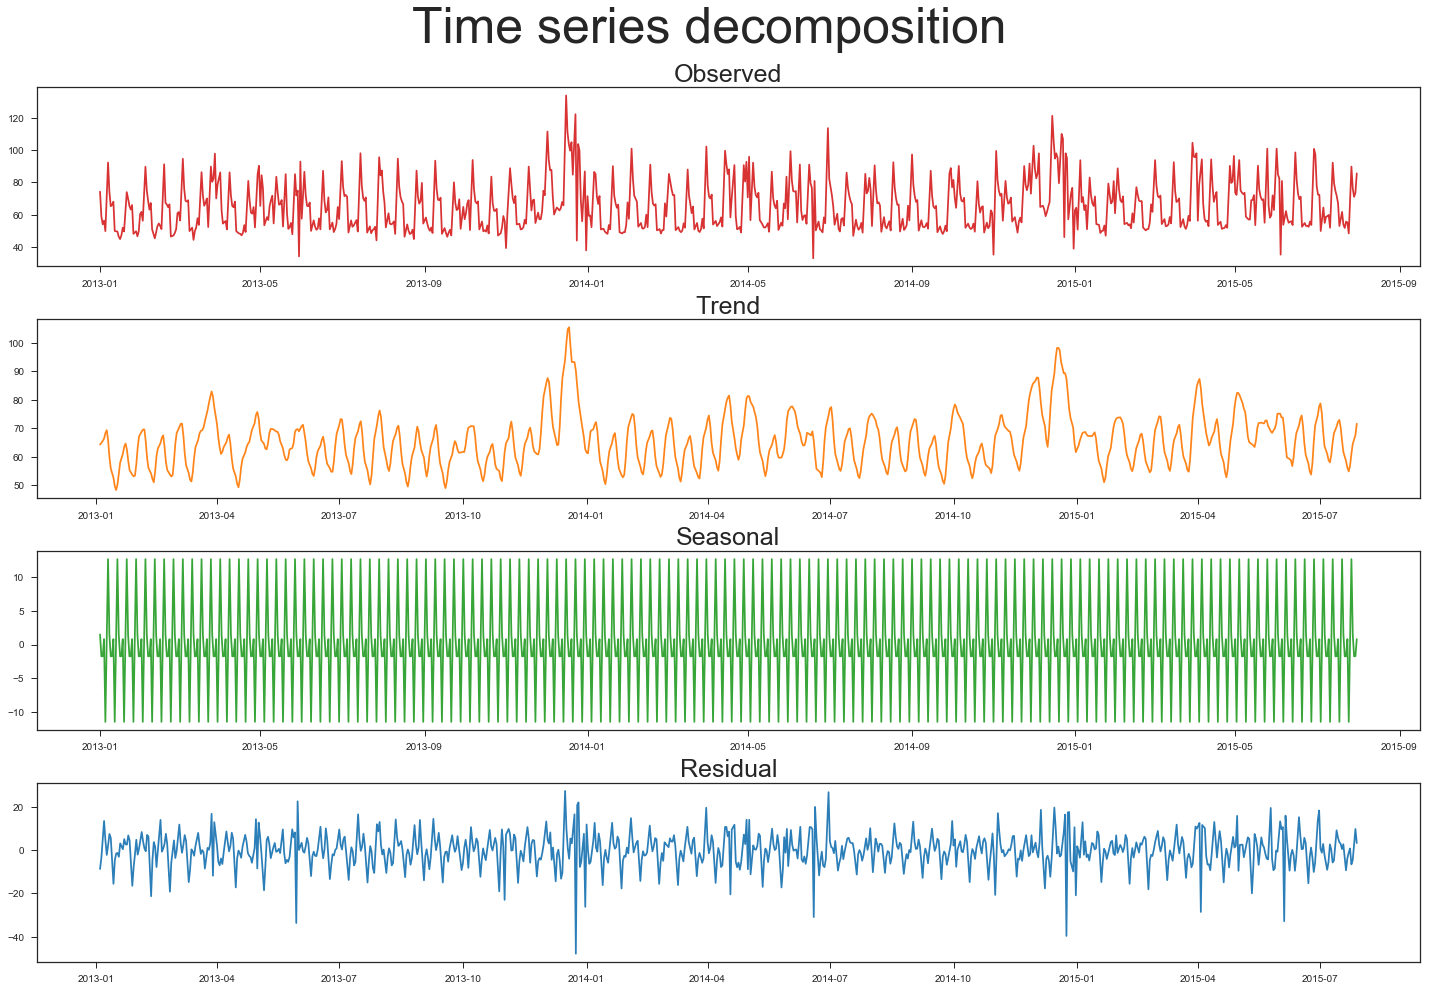

In [15]:
plot_components(basic_decomposition,label='')

In [16]:
#seasonal plot

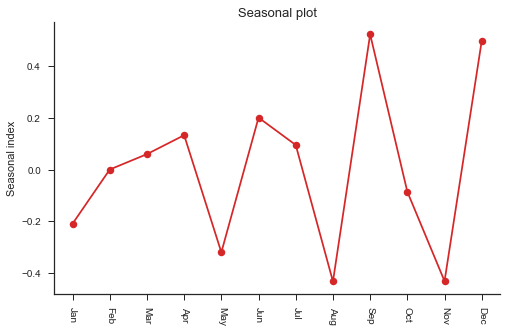

In [17]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(basic_decomposition.seasonal.groupby(basic_decomposition.seasonal.index.month).mean(), color=red, marker='.', markersize=15)
ax.set_xlim(0.5,12.5)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months, rotation='-90')
ax.set_ylabel('Seasonal index')
ax.set_title('Seasonal plot', fontsize=13)
sns.despine()
plt.show()

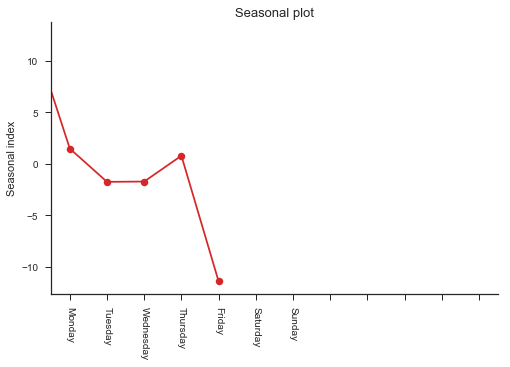

In [76]:
DayOfWeek=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(basic_decomposition.seasonal.groupby(basic_decomposition.seasonal.index.dayofweek).mean(), color=red, marker='.', markersize=15)
ax.set_xlim(0.5,12.5)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(DayOfWeek, rotation='-90')
ax.set_ylabel('Seasonal index')
ax.set_title('Seasonal plot', fontsize=13)
sns.despine()

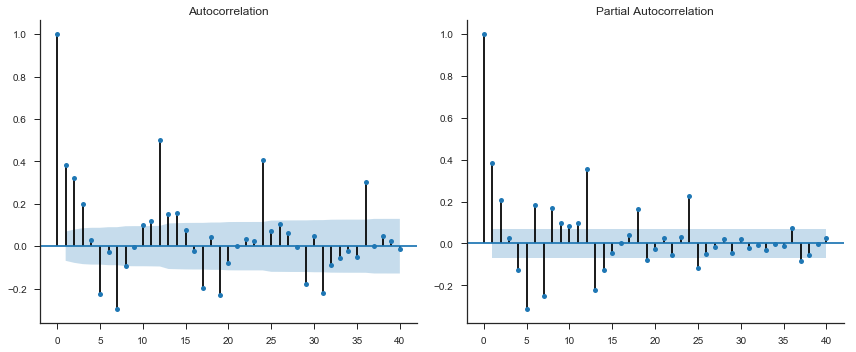

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax[1])
sns.despine()
fig.tight_layout()
plt.show()

# # Modelling

In [19]:
## ARIMA

In [20]:
df=pd.DataFrame(y.copy())
df.columns.values[0]='original'
df['first_diff']=y-y.shift(1)
df['seasonal_diff']=y-y.shift(6)
df['first_season_diff']=df['first_diff']-df['first_diff'].shift(6)
df=df.dropna()
df.tail().round(3)

,original,first_diff,seasonal_diff,first_season_diff
Date,,,,
2015-07-27,89.860,41.458,28.129,32.704
2015-07-28,76.281,-13.579,22.435,-5.694
2015-07-29,71.089,-5.192,19.277,-3.158
2015-07-30,73.617,2.528,17.873,-1.403
2015-07-31,85.615,11.998,30.449,12.576


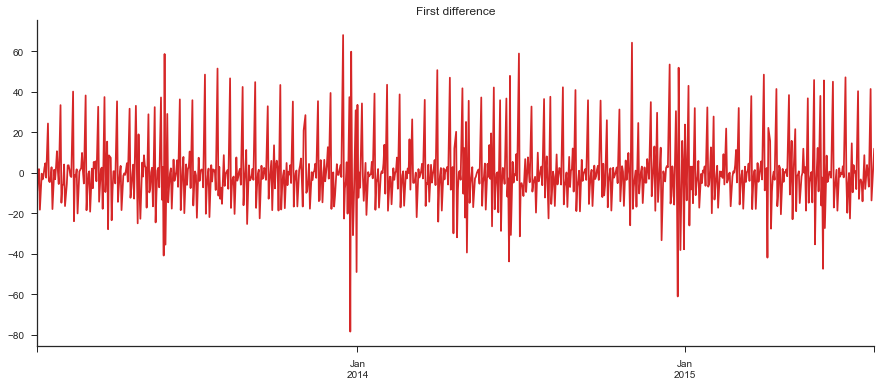

In [21]:
ts_plot(df['first_diff'])
plt.title('First difference')
plt.show()

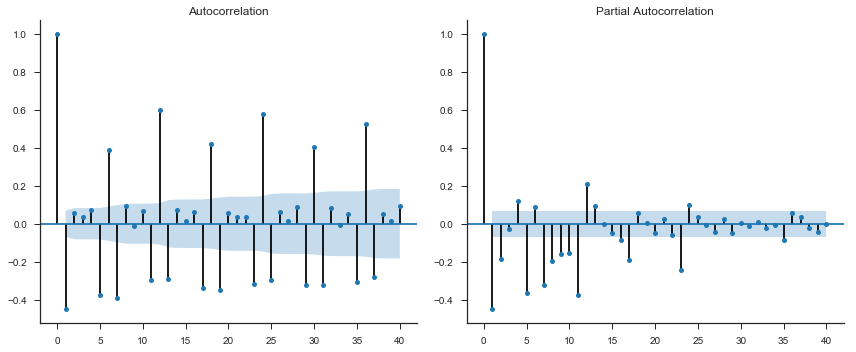

In [22]:
acf_pacf_plot(df['first_diff'])
plt.show()

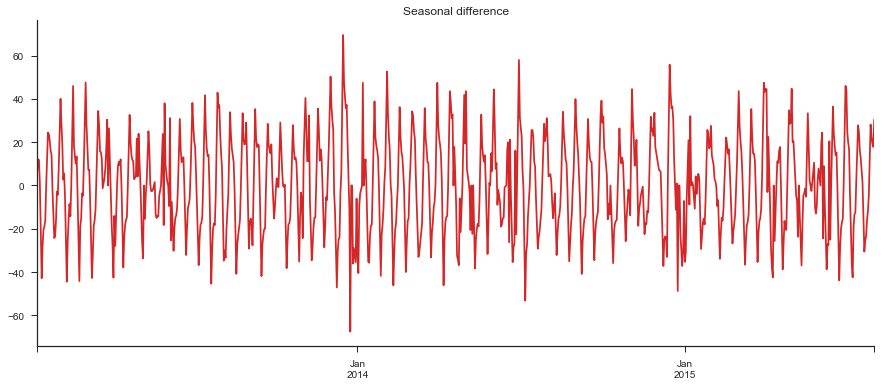

In [23]:
ts_plot(df['seasonal_diff'])
plt.title('Seasonal difference')
plt.show()

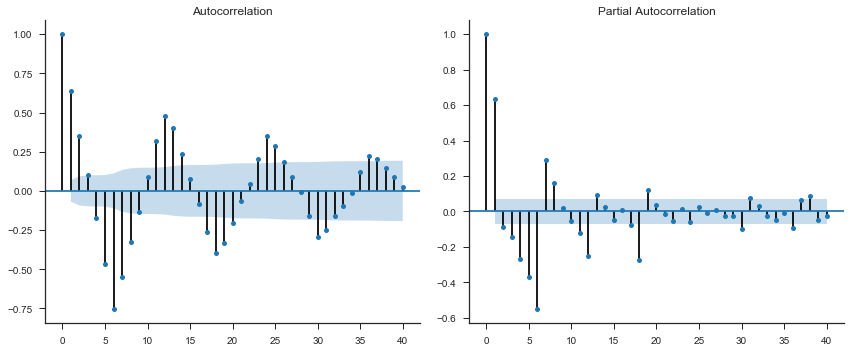

In [24]:
acf_pacf_plot(df['seasonal_diff'])
plt.show()

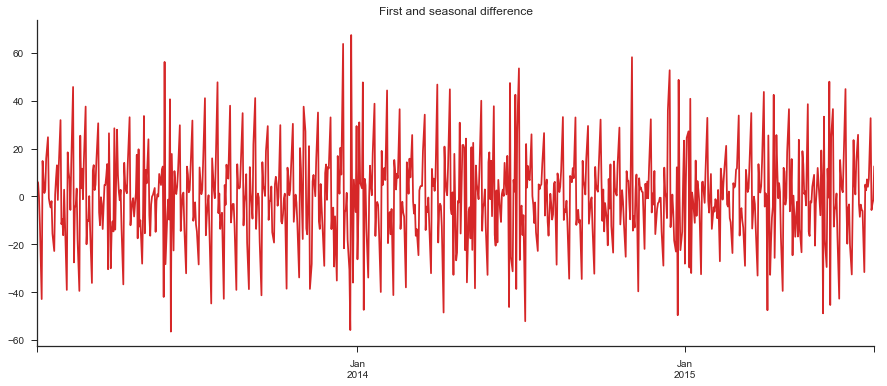

In [25]:
ts_plot(df['first_season_diff']) # first and seasonal difference
plt.title('First and seasonal difference')
plt.show()

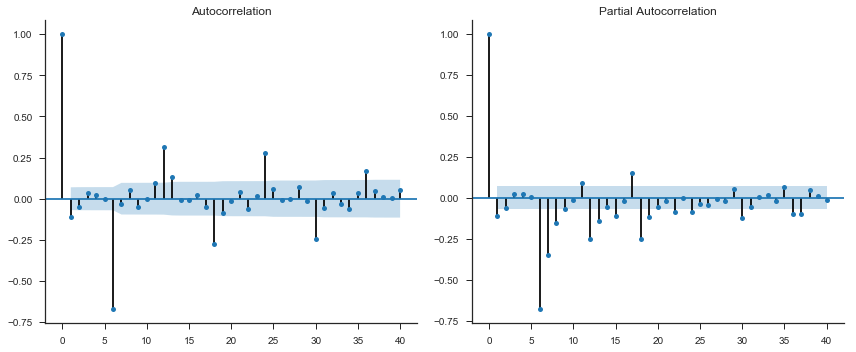

In [26]:
acf_pacf_plot(df['first_season_diff'])
plt.show()

In [27]:
# simple arima
arima1 = sm.tsa.ARIMA(y, order=(6, 1, 1)).fit(trend='nc') # trend='nc' option estimates a model without a drift
print(arima1.aic) 

6416.748466560726


In [28]:
# seasonal arima
sarima_benchmark=sm.tsa.statespace.SARIMAX(y,  order=(6, 1, 1), seasonal_order=(1, 1, 1, 6)).fit()
print(sarima_benchmark.aic)

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


5992.24607572


# ### Automatic selection

In [29]:
def aic_selection_Firstdiff(sarima_benchmark):
    try:
        warnings.filterwarnings('ignore')
        best_score=sarima_benchmark.aic
        best_model=sarima_benchmark
        
        x1= range(8) #(0-7)
        x2= range(1,2) 
        x3= range(8) 
        for i in x1:
            for j in x2:
                for k in x3:
                    if (j==0 and k==6):
                        continue
                    if (j==0 and k==7):
                        continue
                    if (j==1 and k==6):
                        continue
                    if (j==1 and k==7):
                        continue
                    if (i>=1 and i<=5 and j==0 and k==2):
                        continue
                    if (i==2 and j==0 and k==1):
                        continue
                    if (i==2 and j==0 and k==2):
                        continue
                    if (i>=2 and i<=5 and j==1 and k==2):
                        continue
                    if (i==6 and j==1 and k==3):
                        continue
                    if (i==7 and j==0 and k==5):
                        continue
                    if (i==7 and j==1 and k==4):
                        continue
                    if (i==7 and j==1 and k==5):
                        continue
                    model=sm.tsa.statespace.SARIMAX(y,  order=(i, j, k), seasonal_order=(1, 1, 1, 6)).fit()
                    score=model.aic
                    if (score<best_score):
                        best_score=model.aic
                        best_model=model
    except ValueError:
        print("Note that if the following invertible p d q are printed, please add them in (if-continue), otherwise you may not get the best model ")
        print("These variable cannot build model (as cannot invertible ) when p d q :" +str(i)+" "+str(j)+" "+str(k))
        print()
        print("---------------------------currently, the best model is----------------- ")
    print(" we fixed the seasonal part as (1 , 1, 1, 6 ). And select p and q from 0-7. d=1 ")
    print(" Then the best AIC model’s aic is:  ")
    print(best_model.aic)
    print(" Then the best AIC model’s bic is:  ")
    print(best_model.bic)
    return best_model

In [30]:
best_aic_diff=aic_selection_Firstdiff(sarima_benchmark)

 we fixed the seasonal part as (1 , 1, 1, 6 ). And select p and q from 0-7. d=1 
 Then the best AIC model’s aic is:  
5974.70363186
 Then the best AIC model’s bic is:  
6040.42750068


In [31]:
print(best_aic_diff.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(6, 1, 5)x(1, 1, 1, 6)   Log Likelihood               -2973.352
Date:                           Tue, 31 Oct 2017   AIC                           5974.704
Time:                                   13:18:09   BIC                           6040.428
Sample:                               01-01-2013   HQIC                          5999.940
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2590      0.067      3.841      0.000       0.127       0.391
ar.L2          0.0081      0.069      0.117

In [32]:
def aic_selection_noFirstdiff(sarima_benchmark):
    try:
        warnings.filterwarnings('ignore')
        best_score=sarima_benchmark.aic
        best_model=sarima_benchmark
        
        x1= range(8) #(0-7)
        x2= range(1) # 0
        x3= range(8) 
        for i in x1:
            for j in x2:
                for k in x3:
                    if (j==0 and k==6):
                        continue
                    if (j==0 and k==7):
                        continue
                    if (j==1 and k==6):
                        continue
                    if (j==1 and k==7):
                        continue
                    if (i>=1 and i<=5 and j==0 and k==2):
                        continue
                    if (i==2 and j==0 and k==1):
                        continue
                    if (i==2 and j==0 and k==2):
                        continue
                    if (i>=2 and i<=5 and j==1 and k==2):
                        continue
                    if (i==6 and j==1 and k==3):
                        continue
                    if (i==7 and j==0 and k==5):
                        continue
                    if (i==7 and j==1 and k==4):
                        continue
                    if (i==7 and j==1 and k==5):
                        continue
                    model=sm.tsa.statespace.SARIMAX(y,  order=(i, j, k), seasonal_order=(1, 1, 1, 6)).fit()
                    score=model.aic
                    if (score<best_score):
                        best_score=model.aic
                        best_model=model
    except ValueError:
        print("Note that if the following invertible p d q are printed, please add them in (if-continue), otherwise you may not get the best model ")
        print("These variable cannot build model (as cannot invertible ) when p d q :" +str(i)+" "+str(j)+" "+str(k))
        print()
        print("---------------------------currently, the best model is----------------- ")
    print(" we fixed the seasonal part as (1 , 1, 1, 6 ). And select p and q from 0-7. d=0 ")
    print(" Then the best AIC model’s aic is:  ")
    print(best_model.aic)
    print(" Then the best AIC model’s bic is:  ")
    print(best_model.bic)
    return best_model

In [33]:
best_aic_nodiff=aic_selection_noFirstdiff(sarima_benchmark)

 we fixed the seasonal part as (1 , 1, 1, 6 ). And select p and q from 0-7. d=0 
 Then the best AIC model’s aic is:  
5974.00146826
 Then the best AIC model’s bic is:  
6035.03077502


In [34]:
print(best_aic_nodiff.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(5, 0, 5)x(1, 1, 1, 6)   Log Likelihood               -2974.001
Date:                           Tue, 31 Oct 2017   AIC                           5974.001
Time:                                   13:19:37   BIC                           6035.031
Sample:                               01-01-2013   HQIC                          5997.435
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7972      0.740      1.078      0.281      -0.653       2.247
ar.L2         -0.6095      1.163     -0.524

In [36]:
cd'/Users/zhouchenxi/Desktop/QBUS2820/tutw11'

/Users/zhouchenxi/Desktop/QBUS2820/tutw11


In [37]:
import forecast # you need to download the forecast.py file from the LMS

ses=forecast.ses(y)
ses.fit()
fitted=pd.Series(ses.smooth(), index=y.index)
ses.summary()

 Simple exponential smoothing

 Smoothing parameter:
 alpha  0.432 (0.043) 

 In-sample fit:
 MSE               218.284
 Log-likelihood   -3322.364
 AIC               6650.728
 BIC               6664.811


# ## Holt-winters exponential smoothing

In [38]:
import forecast

ahw=forecast.holtwinters(y, additive=True, damped=False, m=6)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.679 (0.042)
 beta  (trend)    0.000 (0.035)
 delta (seasonal) 0.216 (0.042)
 
 In-sample fit:
 MSE               147.122
 RMSE              12.129
 Log-likelihood   -3162.972
 AIC               6333.944
 BIC               6352.723


In [39]:
ahwd=forecast.holtwinters(y, additive=True, damped=True, m=6)
ahwd.fit()
ahwd.summary()

 Additive Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.433 (0.222)
 beta  (trend)    0.572 (0.437)
 delta (seasonal) 0.095 (0.067)
 phi (damping)    0.000 (0.437)
 
 In-sample fit:
 MSE               144.247
 RMSE              12.010
 Log-likelihood   -3154.999
 AIC               6319.998
 BIC               6343.471


In [40]:
mhw=forecast.holtwinters(y, additive=False, damped=False, m=6)
mhw.fit()
mhw.summary()

 Multiplicative Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.726 (0.032)
 beta  (trend)    0.000 (0.037)
 delta (seasonal) 0.228 (0.043)
 
 In-sample fit:
 MSE               145.365
 RMSE              12.057
 Log-likelihood   -3158.118
 AIC               6324.236
 BIC               6343.014


In [41]:
mhw_damped=forecast.holtwinters(y, additive=False, damped=True, m=6)
mhw_damped.fit()
mhw_damped.summary()

 Multiplicative Holt-winters exponential smoothing (damped trend)

 Smoothing parameters:
 alpha (level)    0.726 (0.043)
 beta  (trend)    0.000 (0.042)
 delta (seasonal) 0.227 (0.048)
 phi (damping)    0.541 (0.038)
 
 In-sample fit:
 MSE               145.547
 RMSE              12.064
 Log-likelihood   -3158.624
 AIC               6327.248
 BIC               6350.720


In [42]:
ahw_log=forecast.holtwinters(np.log(y), additive=True, damped=False, m=6)
ahw_log.fit()
ahw_log.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.698 (0.039)
 beta  (trend)    0.000 (0.035)
 delta (seasonal) 0.231 (0.016)
 
 In-sample fit:
 MSE               0.032
 RMSE              0.179
 Log-likelihood    245.665
 AIC               -483.331
 BIC               -464.552


In [43]:
columns=['AIC', 'BIC']
rows=['Simple ARIMA','Simple ARIMA + seasonal part','Seasonal arima with first diff and best AIC','Seasonal arima no first diff and best AIC',
     "Additive Holt-winters ES","Additive Holt-winters ES (damped trend)",
     "Multiplicative Holt-winters ES","Multiplicative Holt-winters ES (damped trend)",'Additive Log-Holt-winters ES (unadjusted AIC)']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
methods=[arima1, sarima_benchmark, best_aic_diff, best_aic_nodiff, ahw, ahwd, mhw, mhw_damped, ahw_log ]

for i, method in enumerate(methods):
    results.iloc[i,0]=method.aic
    results.iloc[i,1]=method.bic
results.round(4)

,AIC,BIC
Simple ARIMA,6416.7485,6454.2951
Simple ARIMA + seasonal part,5992.2461,6039.1917
Seasonal arima with first diff and best AIC,5974.7036,6040.4275
Seasonal arima no first diff and best AIC,5974.0015,6035.0308
Additive Holt-winters ES,6333.9445,6352.7227
Additive Holt-winters ES (damped trend),6319.9984,6343.4712
Multiplicative Holt-winters ES,6324.2357,6343.0139
Multiplicative Holt-winters ES (damped trend),6327.2476,6350.7204
Additive Log-Holt-winters ES (unadjusted AIC),-483.3305,-464.5523


# # Validation

In [44]:
ts=np.log(y)
validation=y['2015':].index
start = y.index.get_loc('2015-01') 

pred1 = [] # additive holt winters
pred2 = [] # additive holt winters dampen
pred3 = [] # mutiplicative holt winters
pred4 = [] # mutiplicative holt winters dampen
pred5 = [] # log additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=6)
    model.fit()
    pred1.append(model.forecast(1)[0]) # additive holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=True, m=6)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast dampen
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=False, m=6)
    model.fit()
    pred3.append(model.forecast(1)[0]) # multiplicate holt winters forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=False, damped=True, m=6)
    model.fit()
    pred4.append(model.forecast(1)[0]) 
    
    model = forecast.holtwinters(ts.iloc[:i], additive=True, damped=False, m=6)
    model.fit()
    resid = (ts.iloc[:i]-model.smooth())[6:] # residuals

    y_pred = np.exp(model.forecast(1)[0])*np.mean(np.exp(resid)) # forecast with a retransformation adjustment 
    pred5.append(y_pred) # long additive holt winters forecast
    
    
columns=['Additive', 'Additive damped', 'Multiplicative', 'Multiplicative damped', 'Log additive', 'Actual']
results = np.vstack([pred1,pred2,pred3,pred4,pred5,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)




In [45]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
Additive,13.861,0.874
Additive damped,13.802,0.823
Multiplicative,14.085,0.940
Multiplicative damped,14.022,0.889
Log additive,14.145,0.937


In [46]:
# Real time forecasting

validation=y['2015':].index
start = y.index.get_loc('2015-01')

results=pd.DataFrame(0.0, index=y.iloc[start:].index, columns=['SES benchmark','Seasonal ARIMA with diff', 'Seasonal ARIMA without diff', 'Actual'])
results['Actual'] = y.iloc[start:]

for i in range(start, len(y)):
    
    j=i-start
        
    model = forecast.ses(y.iloc[:i]) 
    model.fit()
    results.iloc[j,0]=model.forecast(1)[0]
    # seasonal ARIMA
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(1, 1, 1), seasonal_order=(1, 1, 1, 6)).fit()
    results.iloc[j,1]=model.forecast()[0]
    
    model = sm.tsa.statespace.SARIMAX(y.iloc[:i],  order=(1, 0, 1), seasonal_order=(1, 1, 1, 6)).fit()
    results.iloc[j,2]=model.forecast()[0]

In [47]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(len(results.columns)-1):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(3)

,RMSE,SE
SES benchmark,15.945,1.008
Seasonal ARIMA with diff,10.041,0.837
Seasonal ARIMA without diff,9.899,0.848


# ### Diagnostics

for ARIMA, ONLY check the best aic model

Below are the residual plot, ACF and PACF for the ARIMA(6,1,5)(1,1,1,6)model and ARIMA(5,0,5)(1,1,1,6) model. Therea are no apparent patterns in these plots, so that model seems to adequately capture time series dependence in the date.

In [48]:
resid1=best_aic_diff.resid
resid2=best_aic_nodiff.resid

In [49]:
def residual_plot(resid):
    fig, ax= plt.subplots(figsize=(15,5))
    resid.plot(color=blue)
    ax.set_xlabel('')
    ax.set_xticks([], minor=True) 
    ax.set_title('Residual plot')
    sns.despine()
    plt.show()

##### seasonal arima with first diff

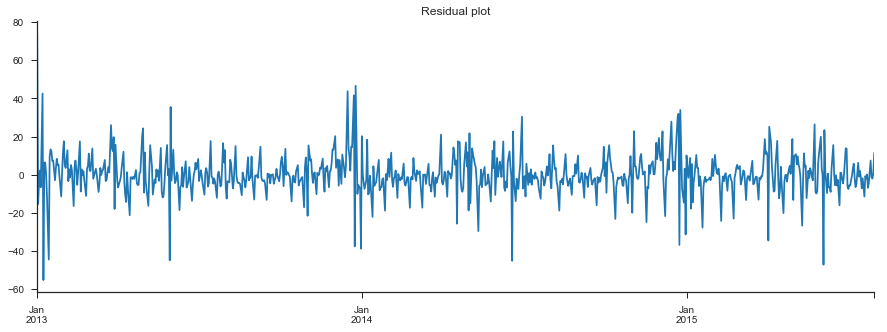

In [45]:
residual_plot(resid1)  # diff

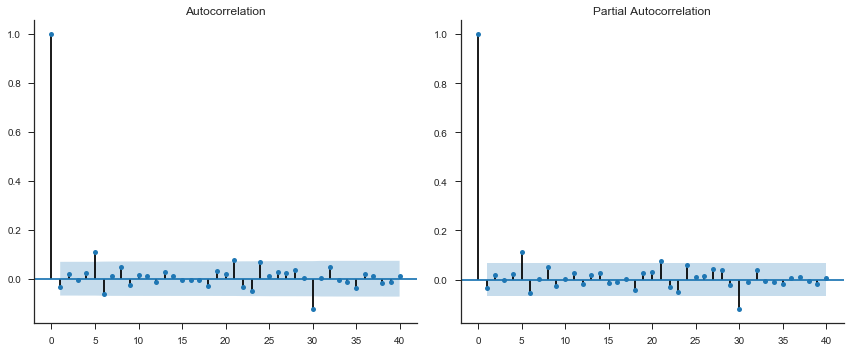

In [46]:
acf_pacf_plot(resid1) # first diff
plt.show()

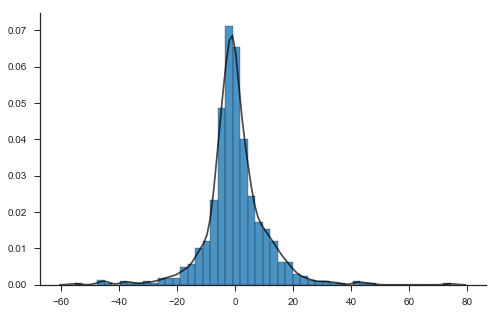

In [47]:
hist(resid1)
plt.show()

In [48]:
best_aic_diff.summary().tables[2]

Ljung-Box (Q):,45.58,Jarque-Bera (JB):,648.45
Prob(Q):,0.25,Prob(JB):,0.00
Heteroskedasticity (H):,1.66,Skew:,-0.05
Prob(H) (two-sided):,0.00,Kurtosis:,7.41


In [49]:
#### seasonal arima without first diff

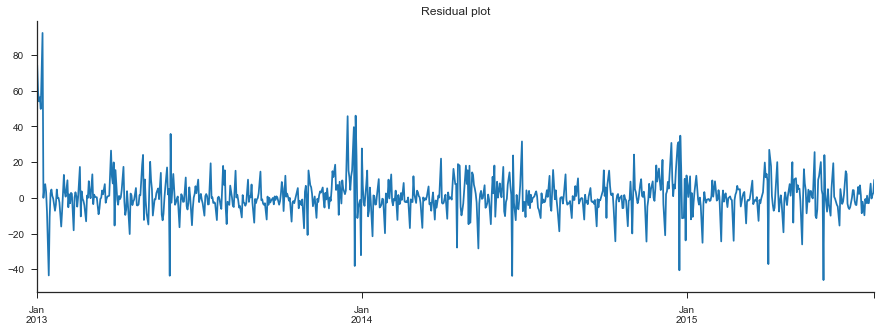

In [50]:
residual_plot(resid2) #residual_plot(resid2) 

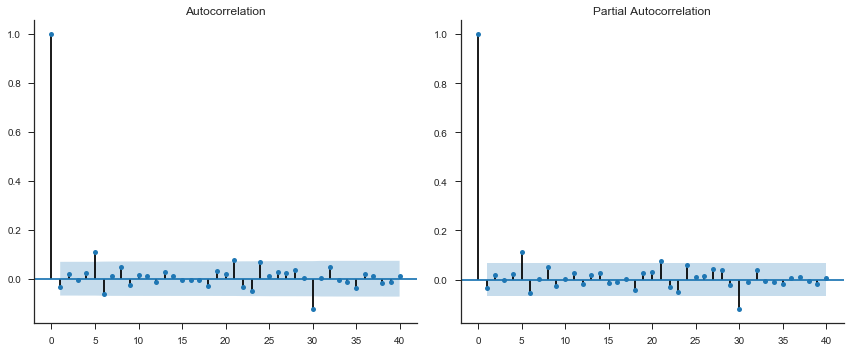

In [51]:
acf_pacf_plot(resid1) #  no first diff
plt.show()

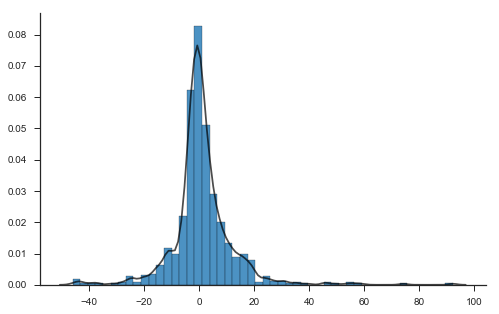

In [52]:
hist(resid2)
plt.show()

In [53]:
best_aic_nodiff.summary().tables[2]

Ljung-Box (Q):,53.74,Jarque-Bera (JB):,672.30
Prob(Q):,0.07,Prob(JB):,0.00
Heteroskedasticity (H):,1.69,Skew:,-0.07
Prob(H) (two-sided):,0.00,Kurtosis:,7.48


# Model

# Additive HW ES

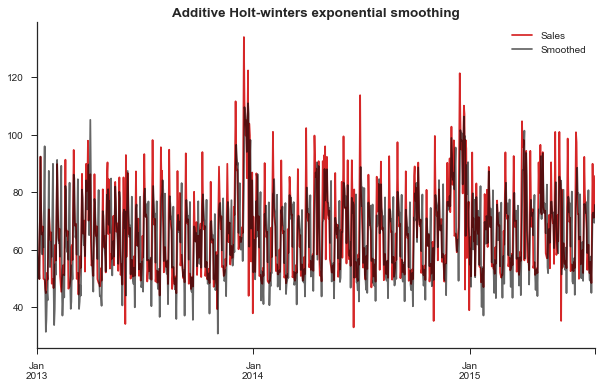

In [57]:
ahw_smoothed=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Sales')
ahw_smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Additive Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

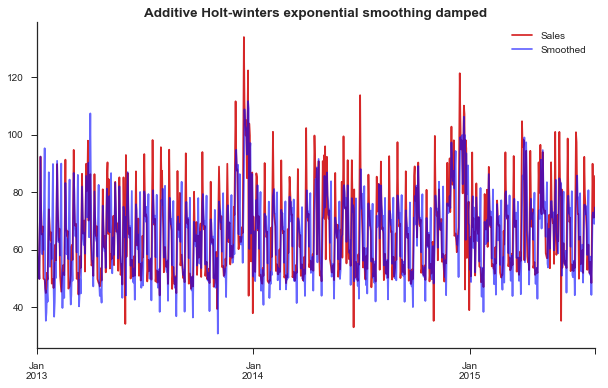

In [58]:
ahwd_smoothed=pd.Series(ahwd.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Sales')
ahwd_smoothed.plot(color='blue', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Additive Holt-winters exponential smoothing damped', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

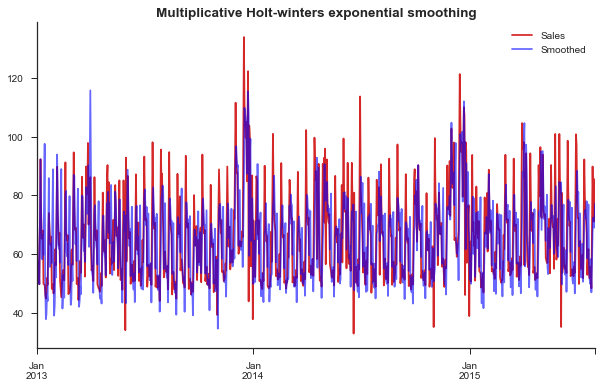

In [59]:
mhw_smoothed=pd.Series(mhw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Sales')
mhw_smoothed.plot(color='blue', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Multiplicative Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

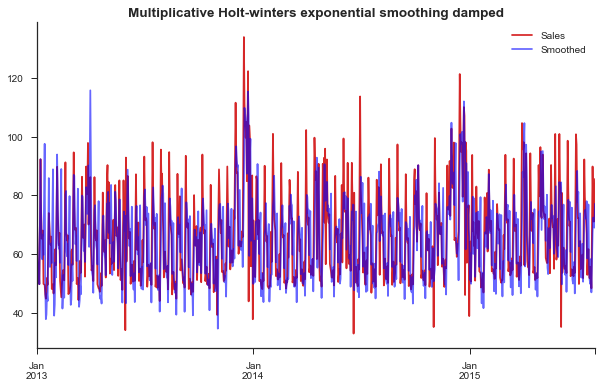

In [60]:
mhw_damped_smoothed=pd.Series(mhw_damped.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Sales')
mhw_damped_smoothed.plot(color='blue', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Multiplicative Holt-winters exponential smoothing damped', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

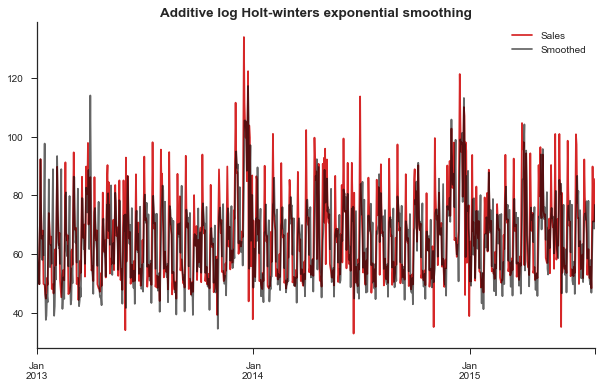

In [62]:
ahw_log_smoothed=pd.Series(np.exp(ahw_log.smooth()), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='Sales')
ahw_log_smoothed.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Additive log Holt-winters exponential smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

# Diagnostic for Ahw

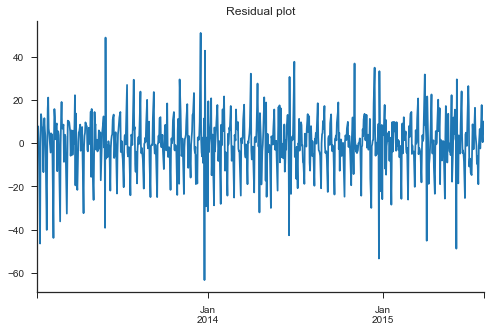

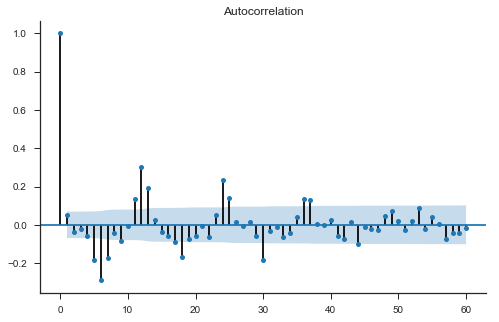

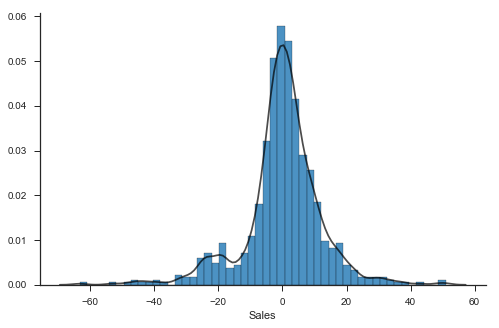

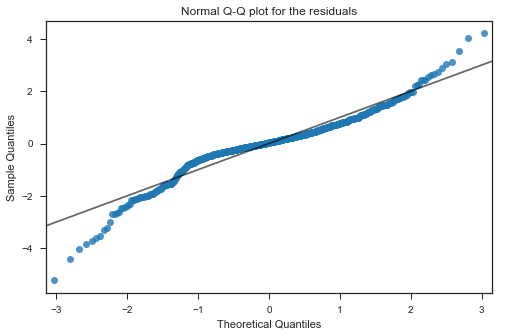

Residual skewness: -0.560
Residual kurtosis: 3.512


In [63]:
resid = (y-ahw.smooth())[6:] # we remove the first 6 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax)
sns.despine()
plt.show()

from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

# Model diagnostic for Additive HW damped

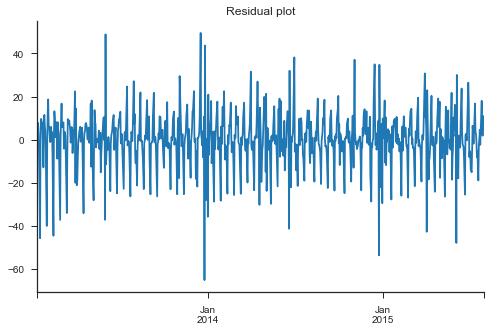

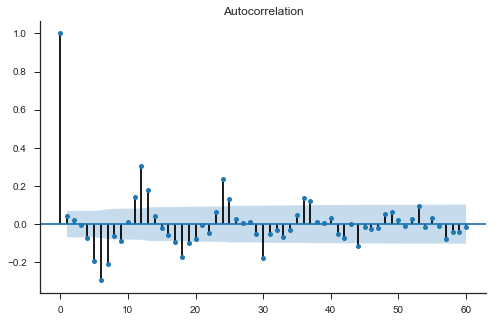

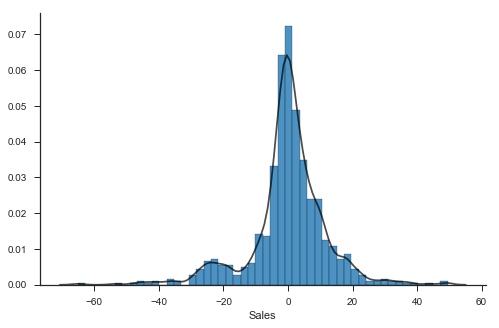

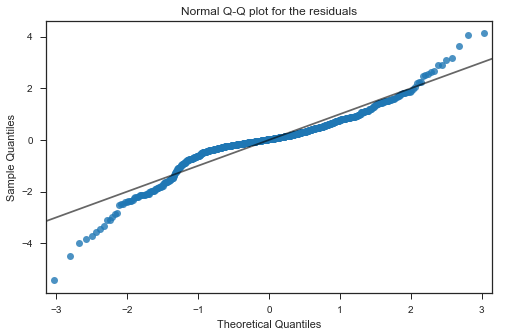

Residual skewness: -0.636
Residual kurtosis: 3.870


In [64]:
resid = (y-ahwd.smooth())[6:] # we remove the first 6 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax)
sns.despine()
plt.show()

from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

# # Model diagnostic for  MHW

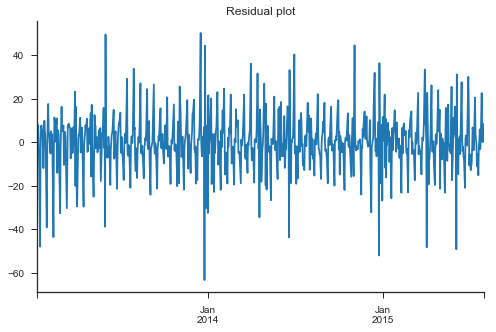

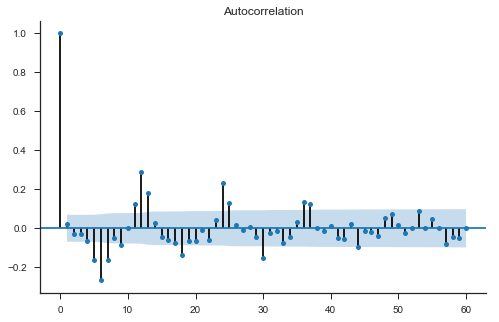

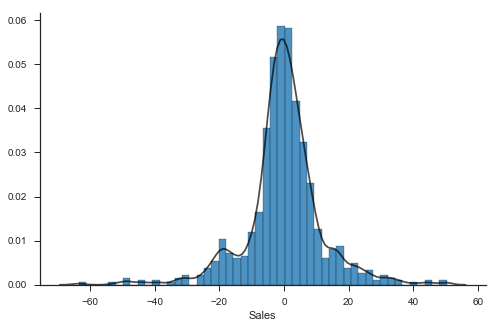

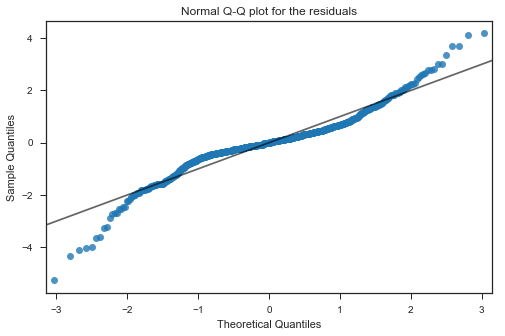

Residual skewness: -0.289
Residual kurtosis: 3.982


In [65]:
resid = (y-mhw.smooth())[6:] # we remove the first 6 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax)
sns.despine()
plt.show()

from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

# Model diagnostic for  MHW damped

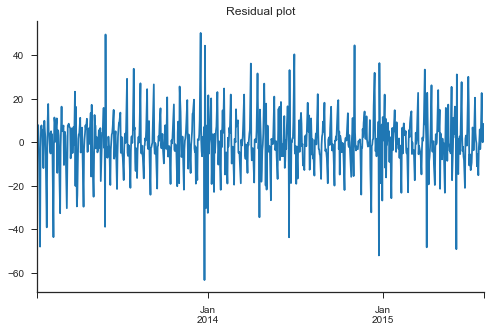

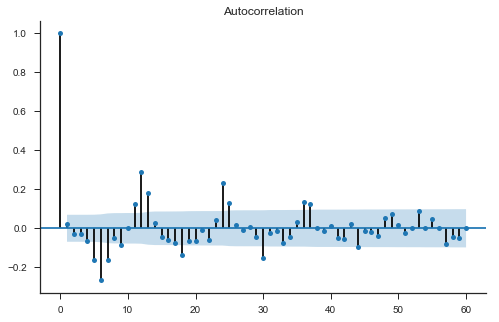

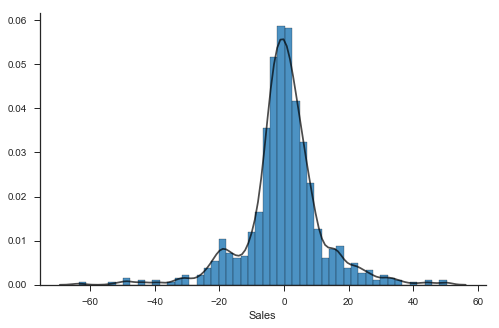

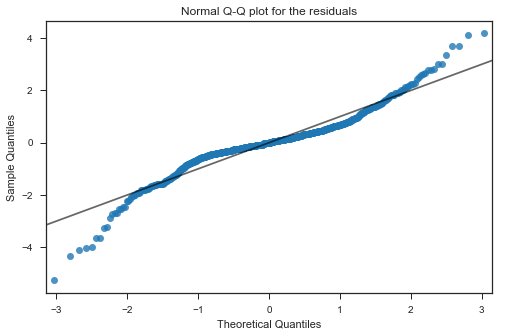

Residual skewness: -0.289
Residual kurtosis: 3.982


In [66]:
resid = (y-mhw_damped.smooth())[6:] # we remove the first 6 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax)
sns.despine()
plt.show()

from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

# Model diagnostic for Additive log 

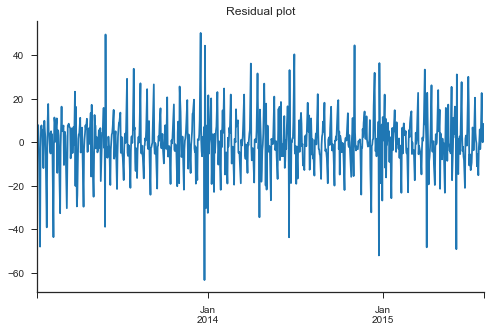

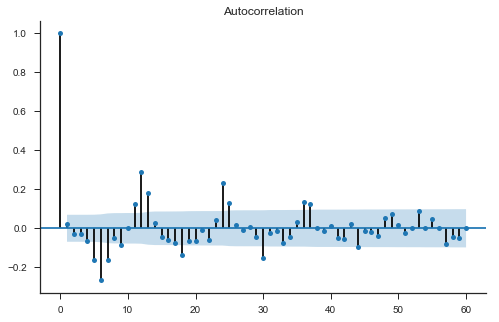

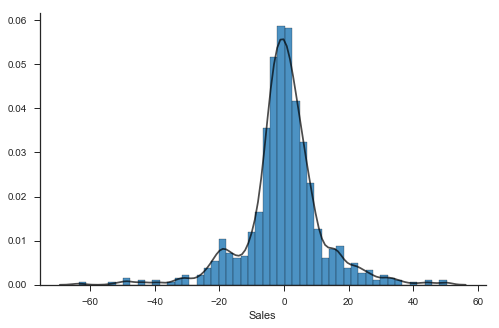

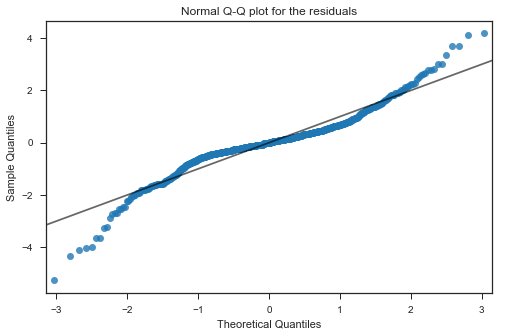

Residual skewness: -0.289
Residual kurtosis: 3.982


In [67]:
resid = (y-mhw_damped.smooth())[6:] # we remove the first 6 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid, lags=60, ax=ax)
sns.despine()
plt.show()

from forecast import histogram, qq_plot

histogram(resid)
plt.show()

qq_plot(resid)
plt.show()

print('Residual skewness: {:.3f}'.format(resid.skew()))
print('Residual kurtosis: {:.3f}'.format(resid.kurt()))

# Forecasting

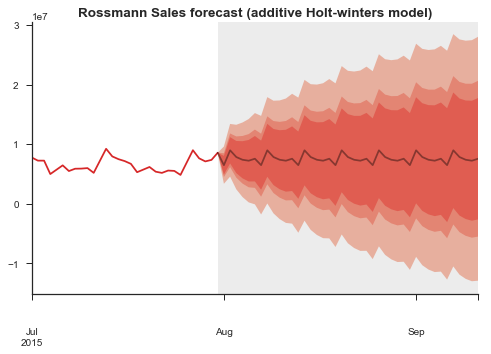

In [81]:
h=42

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

pred=pd.Series(ahw.forecast(h), index=test)
var = ahw.forecastvariance(h)
pred1=pred*10**5 # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahw.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw.intervalforecast(h, level=.99), index=test)
intv1=intv1*10**5
intv2=intv2*10**5
intv3=intv3*10**5


fig, ax = forecast.fanchart(y['07-2015':]*10**5, pred1, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Rossmann Sales forecast (additive Holt-winters model)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [87]:
pred1_table=pd.DataFrame(pred1,index=test)
pred1_table

,0
2015-08-01,6.479925e+06
2015-08-02,8.972398e+06
2015-08-03,7.840281e+06
2015-08-04,7.383462e+06
2015-08-05,7.225095e+06
2015-08-06,7.559288e+06
2015-08-07,6.479925e+06
2015-08-08,8.972398e+06
2015-08-09,7.840281e+06
2015-08-10,7.383462e+06


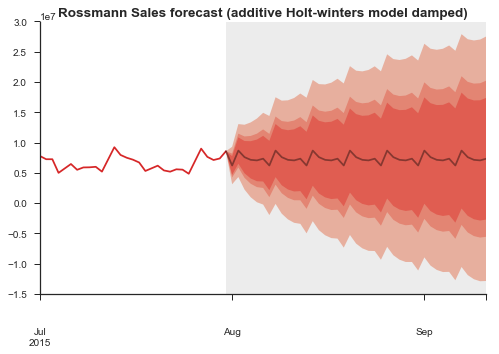

In [88]:
h=42

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

pred=pd.Series(ahwd.forecast(h), index=test)
var = ahwd.forecastvariance(h)
pred2=pred*10**5 # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahwd.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahwd.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahwd.intervalforecast(h, level=.99), index=test)
intv1=intv1*10**5
intv2=intv2*10**5
intv3=intv3*10**5


fig, ax = forecast.fanchart(y['07-2015':]*10**5, pred2, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Rossmann Sales forecast (additive Holt-winters model damped)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [90]:
pred2_table=pd.DataFrame(pred2,index=test)
pred2_table

,0
2015-08-01,6.200072e+06
2015-08-02,8.668092e+06
2015-08-03,7.578761e+06
2015-08-04,7.134846e+06
2015-08-05,7.044890e+06
2015-08-06,7.328817e+06
2015-08-07,6.200072e+06
2015-08-08,8.668092e+06
2015-08-09,7.578761e+06
2015-08-10,7.134846e+06


In [72]:
h=42

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

pred=pd.Series(mhw_damped.forecast(h), index=test)
pred=pred*10**5 # retransformation under the assumption of normality, for simplicity
var = mhw_damped.forecastvariance(h)
intv1=pd.DataFrame(mhw.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(mhw.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(mhw.intervalforecast(h, level=.99), index=test)
intv1=intv1*10**5
intv2=intv2*10**5
intv3=intv3*10**5


fig, ax = forecast.fanchart(y['04-2015':]*10**5, pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Rossmann Sales forecast (Multiplicative Holt-winters model damped)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

AssertionError: Forecast variance not available for h>m in the multiplicative model

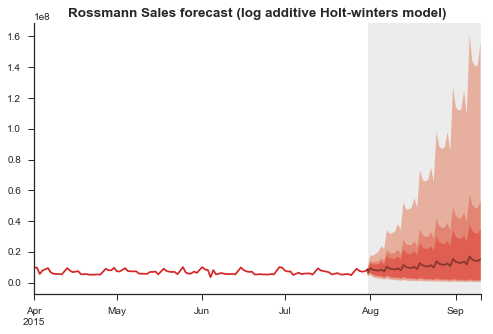

In [96]:
h=42

test=pd.period_range(start=y.index[-1], periods=h, freq='D')

pred=pd.Series(ahw_log.forecast(h), index=test)
var = ahw_log.forecastvariance(h)
pred3=np.exp(pred+var/2)*10**5 # retransformation under the assumption of normality, for simplicity

intv1=pd.DataFrame(ahw_log.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw_log.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw_log.intervalforecast(h, level=.99), index=test)
intv1=np.exp(intv1)*10**5
intv2=np.exp(intv2)*10**5
intv3=np.exp(intv3)*10**5

fig, ax = forecast.fanchart(y['04-2015':]*10**5, pred3, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Rossmann Sales forecast (log additive Holt-winters model)', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [97]:
pred3_table=pd.DataFrame(pred3,index=test)
pred3_table

,0
2015-07-31,6.559206e+06
2015-08-01,9.451122e+06
2015-08-02,8.281405e+06
2015-08-03,7.923293e+06
2015-08-04,7.808708e+06
2015-08-05,8.452618e+06
2015-08-06,7.217380e+06
2015-08-07,1.042350e+07
2015-08-08,9.133440e+06
2015-08-09,8.738484e+06


# ARIMA forecast

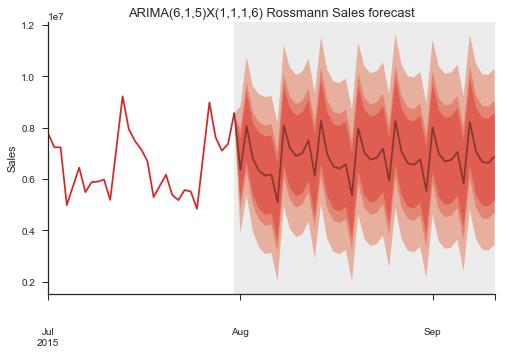

In [100]:
h=42 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred1 = best_aic_diff.forecast(steps=h)
y_pred1 =  pd.Series(y_pred1, index=test)*10**5

intv1 = best_aic_diff.get_forecast(h).conf_int(alpha=0.2)
intv2 = best_aic_diff.get_forecast(h).conf_int(alpha=0.1)
intv3 = best_aic_diff.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)*10**5
intv2=pd.DataFrame(intv2, index=test)*10**5
intv3=pd.DataFrame(intv3, index=test)*10**5


fig, ax = forecast.fanchart(y['2015-07':]*10**5, y_pred1, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(6,1,5)X(1,1,1,6) Rossmann Sales forecast', fontsize=13)
sns.despine()
plt.show()

In [104]:
y_pred1=pd.DataFrame(y_pred1,index=test)
y_pred1

,0
2015-08-01,6.356329e+06
2015-08-02,8.056657e+06
2015-08-03,6.806268e+06
2015-08-04,6.321372e+06
2015-08-05,6.138156e+06
2015-08-06,6.179940e+06
2015-08-07,5.098803e+06
2015-08-08,8.088198e+06
2015-08-09,7.197050e+06
2015-08-10,6.900887e+06


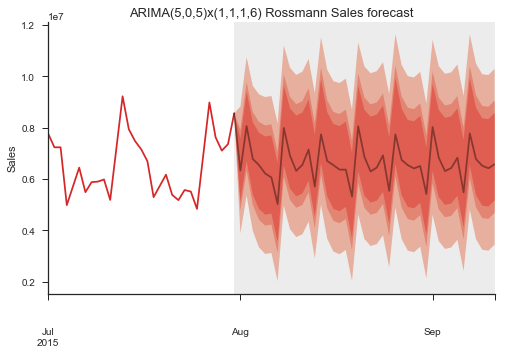

In [101]:
h=42 

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='D')

y_pred2 = best_aic_nodiff.forecast(steps=h)
y_pred2 =  pd.Series(y_pred2, index=test)*10**5

intv1 = best_aic_diff.get_forecast(h).conf_int(alpha=0.2)
intv2 = best_aic_diff.get_forecast(h).conf_int(alpha=0.1)
intv3 = best_aic_diff.get_forecast(h).conf_int(alpha=0.01)

intv1=pd.DataFrame(intv1, index=test)*10**5
intv2=pd.DataFrame(intv2, index=test)*10**5
intv3=pd.DataFrame(intv3, index=test)*10**5


fig, ax = forecast.fanchart(y['2015-07':]*10**5, y_pred2, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_ylabel('Sales')
ax.set_title('ARIMA(5,0,5)x(1,1,1,6) Rossmann Sales forecast', fontsize=13)
sns.despine()
plt.show()

In [105]:
y_pred2=pd.DataFrame(y_pred2,index=test)
y_pred2

,0
2015-08-01,6.331911e+06
2015-08-02,8.064801e+06
2015-08-03,6.784053e+06
2015-08-04,6.544587e+06
2015-08-05,6.218684e+06
2015-08-06,6.065698e+06
2015-08-07,5.029506e+06
2015-08-08,7.994217e+06
2015-08-09,6.914241e+06
2015-08-10,6.320873e+06
